In [1]:
!eups list -s | grep lsst_distrib

lsst_distrib          g4213664e8e+86c9cca404 	current w_2024_19 setup


In [2]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import healpy as hp
import pandas as pd
from matplotlib import cm
# %matplotlib widget

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from lsst.daf.butler import Butler

In [5]:
rng = np.random.default_rng(seed=12)

arcmin = 1/60
arcsec = 1/3600

In [6]:
# Relevant bands
bands = list('ugrizy')
# bands = list('gri')
blen = len(bands)

# Column names for the bands

ap_suffix = '_ap12Flux'
kron_suffix = '_kronFlux'

aper_bands = [b+ap_suffix for b in bands]
kron_bands = [b+kron_suffix for b in bands]


# Load Observed Data

Using processed Operations Rehearsal 3 data.


In [7]:
# Load operation rehearsal data
# Can use obs_butler.registry.queryCollections to see available collections

obs_repo = '/repo/embargo'
obs_collection = 'LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry

In [8]:
# Get the data for the first tract listed

objTables = np.array(list(obs_registry.queryDatasets('objectTable_tract')))
print(objTables[0])

objectTable_tract@{skymap: 'ops_rehersal_prep_2k_v1', tract: 9812} [sc=DataFrame] (run=LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865/20240413T021427Z id=de37cd19-6b71-4ef7-8768-cd3bb5804b40)


In [9]:
all_tracts = [ot.dataId['tract'] for ot in objTables]

In [250]:
# Load object catalog

# skymap = 'DC2'
skymap='ops_rehersal_prep_2k_v1'
# tract = all_tracts[0]
# tract = 3533
# patch=38

# detect_isIsolated marks sources that are not contained in a blend (using the overlapping footprint definition). Should be interesting to look at results with this cut as well

obj_tracts = []
# for tract in all_tracts[13:14]:
for tract in [9638]:
    print(tract)
    obj_tracts.append(obs_butler.get('objectTable_tract', skymap=skymap, tract=tract,
                           parameters={"columns":['coord_ra', 'coord_dec', 'refExtendedness',
                                                  'detect_isPrimary', 'detect_fromBlend', 'parentObjectId',
                                                  'shape_xx', 'shape_xy', 'shape_yy'] + aper_bands + kron_bands}))

9638


In [251]:
obj_tract = pd.concat(obj_tracts)

In [252]:
for b in bands:
    kron_mag_name = b+'_kron_mag'
    aper_mag_name = b+'_aper_mag'
    obj_tract[kron_mag_name] = u.nJy.to(u.ABmag, obj_tract[b+kron_suffix])
    obj_tract[aper_mag_name] = u.nJy.to(u.ABmag, obj_tract[b+ap_suffix])

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt

In [253]:
primary_tract = obj_tract[obj_tract['detect_isPrimary']]

In [254]:
print(f"RA distance in arcmin {(obj_tract['coord_ra'].max() - obj_tract['coord_ra'].min()) * 60}")
print(f"DEC distance in arcmin {(obj_tract['coord_dec'].max() - obj_tract['coord_dec'].min()) * 60}")

RA distance in arcmin 56.138138455310695
DEC distance in arcmin 17.765317980377596


# Load truth catalogs

Load and match the galaxy/star catalogs along with the computed fluxes which need to be converted into magnitudes.


In [255]:
# Prepare to read in the parquet files

# parq_dir might change! Double check that the folder exists and the parquet
# files are all there

parq_gal_columns = ["galaxy_id", "ra", "dec"] # Can match with galaxy_flux to get proper fluxes
parq_star_columns = ['object_type', 'ra', 'dec', 'magnorm']
parq_dir = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-3/imSim_catalogs/skyCatalogs/'# Read and store parquet

# This loads only the pixels that we are actually probing. If we have one or two tracts use the line below.
# This also only loads the primary sources which is a lot less problematic.
parq_filenums = list(set(hp.pixelfunc.ang2pix(32, obj_tract['coord_ra'], obj_tract['coord_dec'], lonlat=True)))
gal_nums = parq_filenums
star_nums = parq_filenums

# # This loads all the files:
# all_fnums = os.listdir(parq_dir)
# gal_nums = [int(k[12:-8]) for k in all_fnums if 'galaxy_flux' in k]
# star_nums = [int(k[17:-8]) for k in all_fnums if 'pointsource_flux' in k]

# parq_columns = ["galaxy_id", "ra", "dec", "disk_magnorm", "bulge_magnorm"] 


# gal_bad_exts = [7309, 7789, 7437, 10638, 8929]
# star_bad_exts = [7788, 10638, 7532, 7437, 7789, 7660, 7916]

# bad_exts = [7309, 7789, 7437, 10638, 8929, 7788]

gal_parqs = []
gal_flux_parqs = []

for pf in gal_nums:
    # if pf in gal_bad_exts:
    #     continue
    gal_parqs.append(pd.read_parquet(parq_dir + f'galaxy_{pf}.parquet', columns=parq_gal_columns))
    gal_flux_parqs.append(pd.read_parquet(parq_dir + f'galaxy_flux_{pf}.parquet'))

star_parqs = []
star_flux_parqs = []

for pf in star_nums:
    # if pf in star_bad_exts:
    #     continue
    star_parqs.append(pd.read_parquet(parq_dir + f'pointsource_{pf}.parquet', columns=parq_star_columns))
    star_flux_parqs.append(pd.read_parquet(parq_dir + f'pointsource_flux_{pf}.parquet'))

In [256]:
star_cat = pd.concat(star_parqs)
del star_parqs

gal_cat = pd.concat(gal_parqs)
del gal_parqs

star_flux_cat = pd.concat(star_flux_parqs)
del star_flux_parqs

gal_flux_cat = pd.concat(gal_flux_parqs)
del gal_flux_parqs

In [257]:
# star_cat = pd.concat(star_parqs)
# gal_cat = pd.concat(gal_parqs)

# star_flux_cat = pd.concat(star_flux_parqs)
# gal_flux_cat = pd.concat(gal_flux_parqs)


In [258]:
# See thread started by Shuang Liang in #rubinobs-sciunit-sample-production from Jim Chiang on April 22nd 2024

# TODO: Update this to be not a hardcoded block
true_zps = {'u': 12.652350670009373, 
            'g': 14.689449213373276,
            'r': 14.559501946792281,
            'i': 14.378976834902065,
            'z': 13.993052964496345,
            'y': 13.017367314857484 }


In [259]:
# Convert fluxes to AB mags
for b in bands:
    # gal_flux_cat[f'lsst_mag_{b}'] = u.Jansky.to(u.ABmag, gal_flux_cat[f'lsst_flux_{b}'])
    # star_cat[f'lsst_mag_{b}'] = u.Jansky.to(u.ABmag, star_flux_cat[f'lsst_flux_{b}'])
    gal_flux_cat[f'lsst_mag_{b}'] = true_zps[b] - 2.5*np.log10(gal_flux_cat[f'lsst_flux_{b}'])
    star_cat[f'lsst_mag_{b}'] = true_zps[b] - 2.5*np.log10(star_flux_cat[f'lsst_flux_{b}'])

In [260]:
# Store them in a nice set of catalogs

gal_full = pd.merge(gal_cat, gal_flux_cat, how='outer', on='galaxy_id')
del gal_cat
del gal_flux_cat

In [261]:
# Store them in a nice set of catalogs

star_full = star_cat # Just renaming to keep consistent between star / galaxy variables

# Matching

Use the catalogs to create KDTrees and then match


In [262]:
# Fetch RA-DEC and store in a nice Nx2 array 
# Can extend this to include other shape parameters

true_gal_coords = np.vstack((gal_full['ra'], gal_full['dec'])).T
true_gal_len = len(true_gal_coords)
true_star_coords = np.vstack((star_full['ra'], star_full['dec'])).T

true_coords = np.vstack((true_gal_coords, true_star_coords))
Ntg = len(true_gal_coords)

# Construct the truth tree!
true_tree = KDTree(true_coords)

In [263]:
# Fetch object coordinates and create tree

tract_coords = np.vstack((primary_tract['coord_ra'], primary_tract['coord_dec'])).T
obj_tree = KDTree(tract_coords)

In [264]:
# Create trees on galaxies only! 
# Either using true_gal or where refExtendedness==1

true_gal_tree = KDTree(true_gal_coords)

obj_gal_filt = primary_tract['refExtendedness'].astype(bool)
obj_gal_coords = np.vstack((primary_tract['coord_ra'][obj_gal_filt], primary_tract['coord_dec'][obj_gal_filt])).T
obj_gal_tree = KDTree(obj_gal_coords)

## Star - Galaxy Checks

In [265]:
obj_coords = np.vstack((primary_tract['coord_ra'], primary_tract['coord_dec'])).T
matched_extended = np.zeros(len(obj_coords))

In [266]:
obs_star_coords = obj_coords[~primary_tract['refExtendedness'].astype(bool)] # Objects detected as stars
obs_gal_coords = obj_coords[primary_tract['refExtendedness'].astype(bool)] # Objects detected as galaxies/extended

In [267]:
isolated_stars = []

for i,sc in enumerate(obs_star_coords):
    match_ndx = true_tree.query_ball_point(sc, 1*arcsec)
    if len(match_ndx)==1:
        isolated_stars.append(match_ndx)

In [268]:
# How far are the nearest objects to all objects?

nm_dists = np.zeros(len(obj_coords))

for i,nm_coord in enumerate(obj_coords):
    d, _ = true_tree.query(nm_coord)
    nm_dists[i] = d

In [269]:
no_matches = nm_dists > arcsec

In [270]:
imag_filt = primary_tract['i_kron_mag'] < 24.5

In [271]:
np.sum(nm_dists[imag_filt] > arcsec) / np.sum(imag_filt)

0.6651811891638325

Text(0.5, 1.0, 'Tract 7149 w/ i<24.5')

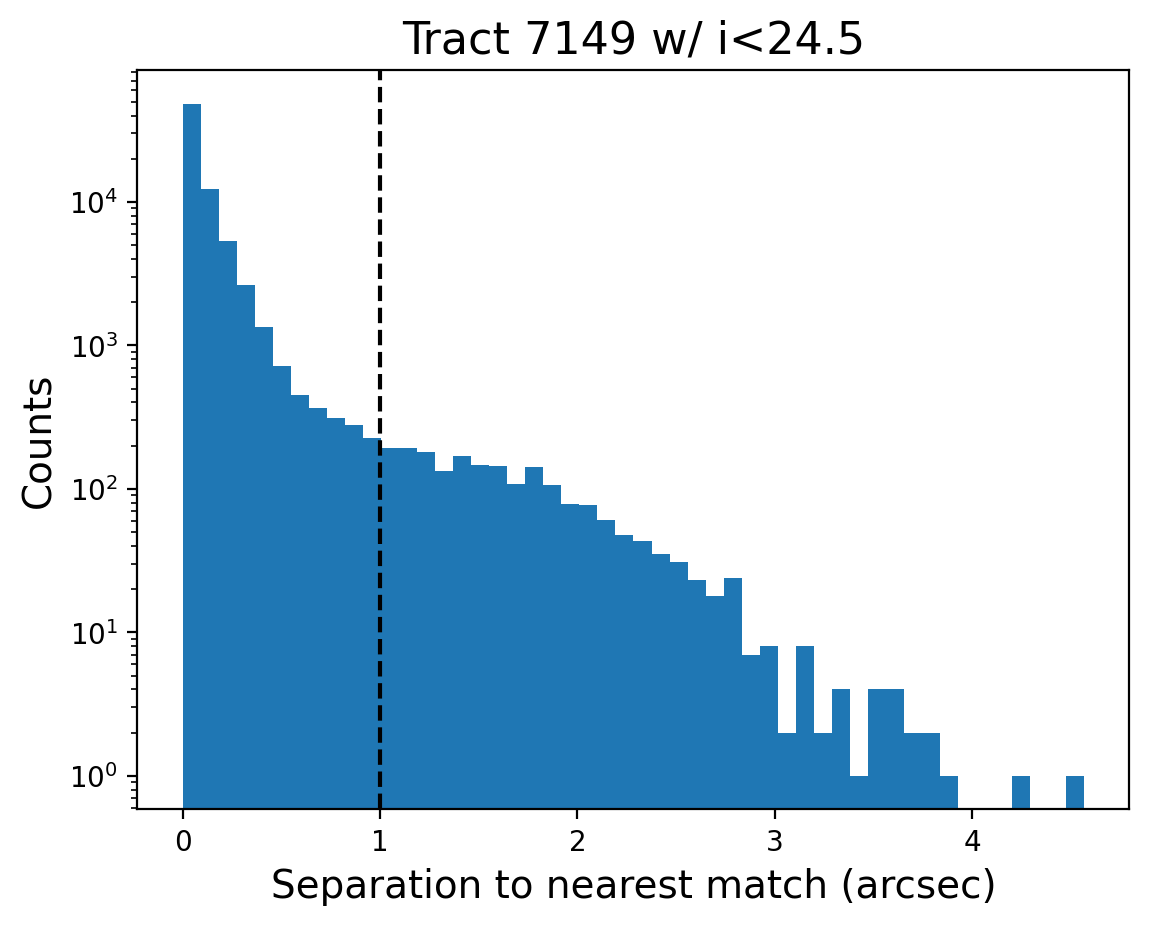

In [247]:
plt.hist(nm_dists[imag_filt] * 3600, bins=50)
plt.axvline(x=1, color='black', ls='--')
plt.semilogy()
plt.xlabel("Separation to nearest match (arcsec)", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title(f"Tract {tract} w/ i<24.5", fontsize=16)

In [107]:
print(f"We find {len(isolated_stars)} isolated objects out of {np.sum(~primary_tract['refExtendedness'].astype(bool))} observed non-extended.")
iso_frac = len(isolated_stars)/np.sum(~primary_tract['refExtendedness'].astype(bool))
print(f"While {iso_frac*100:2.1f}% of the non-extended objects are isolated, how many are stars / galaxies / blends?")

We find 36114 isolated objects out of 45860 observed non-extended.
While 78.7% of the non-extended objects are isolated, how many are stars / galaxies / blends?


In [108]:
# There is probably a smarter way to do this
# but this feels like the clearest way.

# Even with using a dictionary we can re-order to make the code
# a smidge faster but it will be less readable so we don't.

match_type_dict = {0: 'Isolated Star', 1: 'Isolated Galaxy', 2: 'Galaxy+Galaxy',
                   3:'Star+Star', 4: 'Galaxy+Star', 5: 'Misc',
                   6: 'No Match', 7:'NM - Mag Cut'}

matched_extended = np.zeros(len(obj_coords))

In [109]:
# Get matches within 1'' and match/filter on magnitude as well
# How many labeled stars are isolated stars ==> Star Purity
# How many labeled galaxies are either isolated stars or blend including a star (brighter object) ==> Galaxy Contamination
# Isolated == Brightest object (by 2.5mags) within 1''

for i,ne in enumerate(obj_coords):
    
    match_ndx = true_tree.query_ball_point(ne, 1*arcsec)
    # Nothing shows up?
    if len(match_ndx)==0:
        matched_extended[i] = 6
        continue

    # Get magnitudes of matches
    match_mags = np.zeros(len(match_ndx))
    for mi, mndx in enumerate(match_ndx):
        if mndx >= Ntg:
            match_mags[mi] = star_full['lsst_mag_i'].iloc[mndx-Ntg]
        else:
            match_mags[mi] = gal_full['lsst_mag_i'].iloc[mndx]

    # Check that we have objects brighter than 28 mags
    match_ndx = np.array(match_ndx)
    absol_filt = match_mags < 28

    # Our matched object is dimmer than 28 mags?
    if np.sum(absol_filt)==0:
        # If we observe something with truth objects below cutoff
        # assign to the special no match case
        matched_extended[i] = 7
        continue

    if np.sum(absol_filt)==1:
        mndx = match_ndx[absol_filt]
        # If we have 1 object, it's either an isolated star
        # or an isolated galaxy.
        matched_extended[i] = 0 if mndx > Ntg else 1
    else:
        # We have multiple objects so now we can order by brightness
        # and remove any thing that is too dim in comparison
        
        mag_diff = match_mags - match_mags.min()
        mag_diff_filt = mag_diff < 2.5    
        both_filt = mag_diff_filt * absol_filt
        filt_matches = match_ndx[both_filt]
        
        # print(filt_matches, match_mags, mag_diff)
        if len(filt_matches)==1:
            # After filtering we go back to only 1 object?
            # Isolated like above
            matched_extended[i] = 0 if filt_matches[0] > Ntg else 1
             # 3:'Star+Star', 4: 'Galaxy+Star', 5: 'Misc', 6: 'No Match'}
        elif len(filt_matches)==2:
            ndx_type = filt_matches < Ntg
            if np.sum(ndx_type)==2:
                # Galaxy + Galaxy
                matched_extended[i] = 2
            elif np.sum(ndx_type)==1:
                # Galaxy + star
                matched_extended[i] = 4
            else:
                # Star + Star
                matched_extended[i] = 3
        else:
            # Still many matches! Let's shelve this for now...
            matched_extended[i] = 5

In [110]:
imag_filt = primary_tract['i_kron_mag'] < 24.5

me_bins = np.arange(8)
me_hist = [np.sum(matched_extended==c)/len(matched_extended) for c in range(8)]
me_hist_filt = [np.sum(matched_extended[imag_filt]==c)/len(matched_extended[imag_filt]) for c in range(8)]

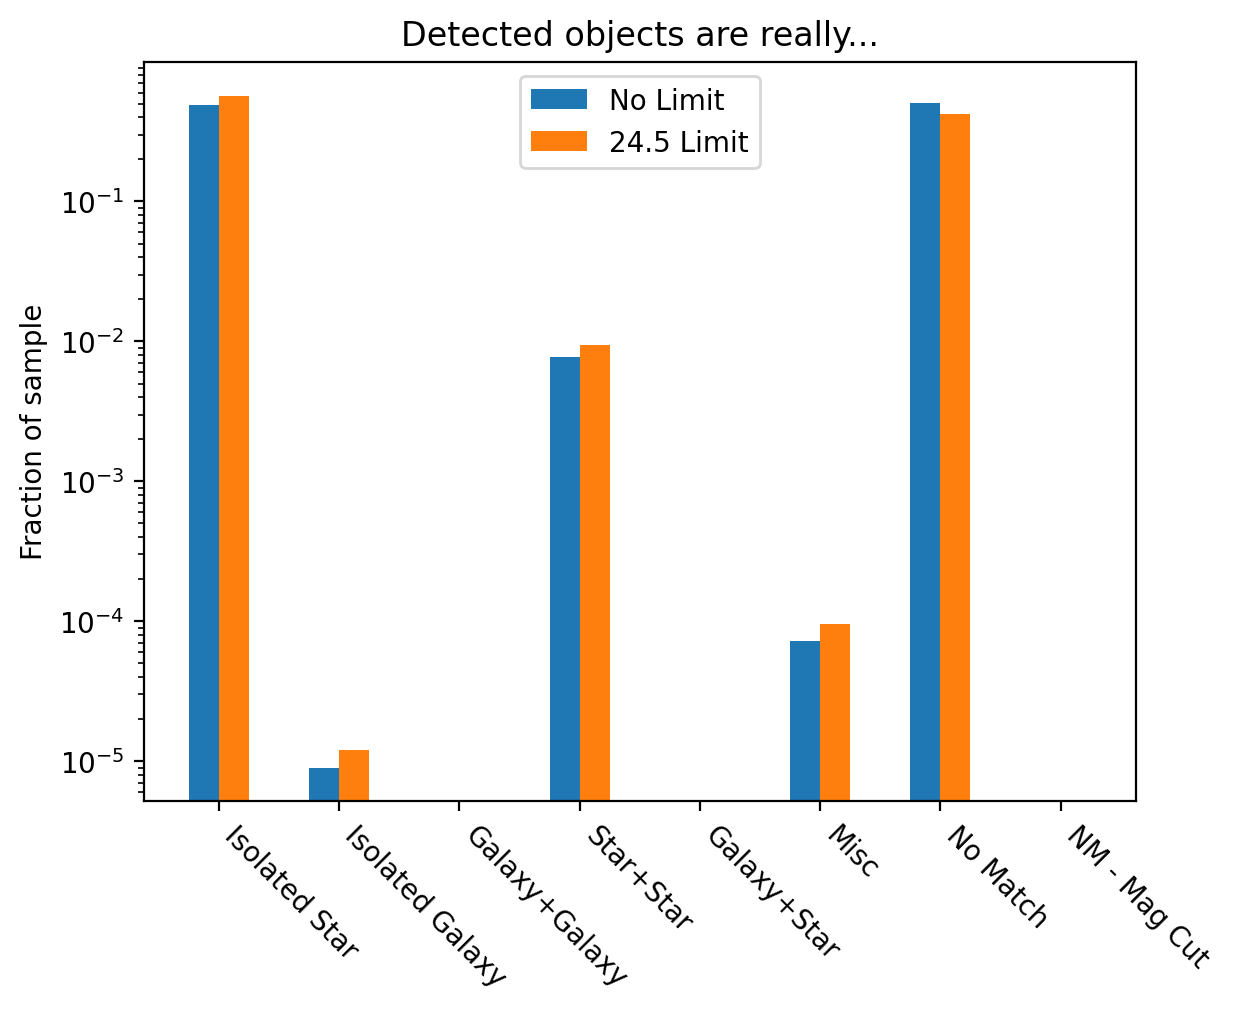

In [111]:
plt.bar(me_bins, me_hist, width=.25, label="No Limit")
plt.bar(me_bins+.25, me_hist_filt, label="24.5 Limit", width=.25)
plt_labels = [match_type_dict[i] for i in range(8)]
plt.title("Detected objects are really...")
plt.xticks(np.arange(8)+.125, plt_labels, rotation=-45, ha="left")
plt.ylabel("Fraction of sample")
plt.legend()
plt.semilogy();

In [116]:
match_type_dict

{0: 'Isolated Star',
 1: 'Isolated Galaxy',
 2: 'Galaxy+Galaxy',
 3: 'Star+Star',
 4: 'Galaxy+Star',
 5: 'Misc',
 6: 'No Match',
 7: 'NM - Mag Cut'}

In [121]:
true_tree.query(obj_coords[0], 1)

(6.193216103305167e-06, 7125453)

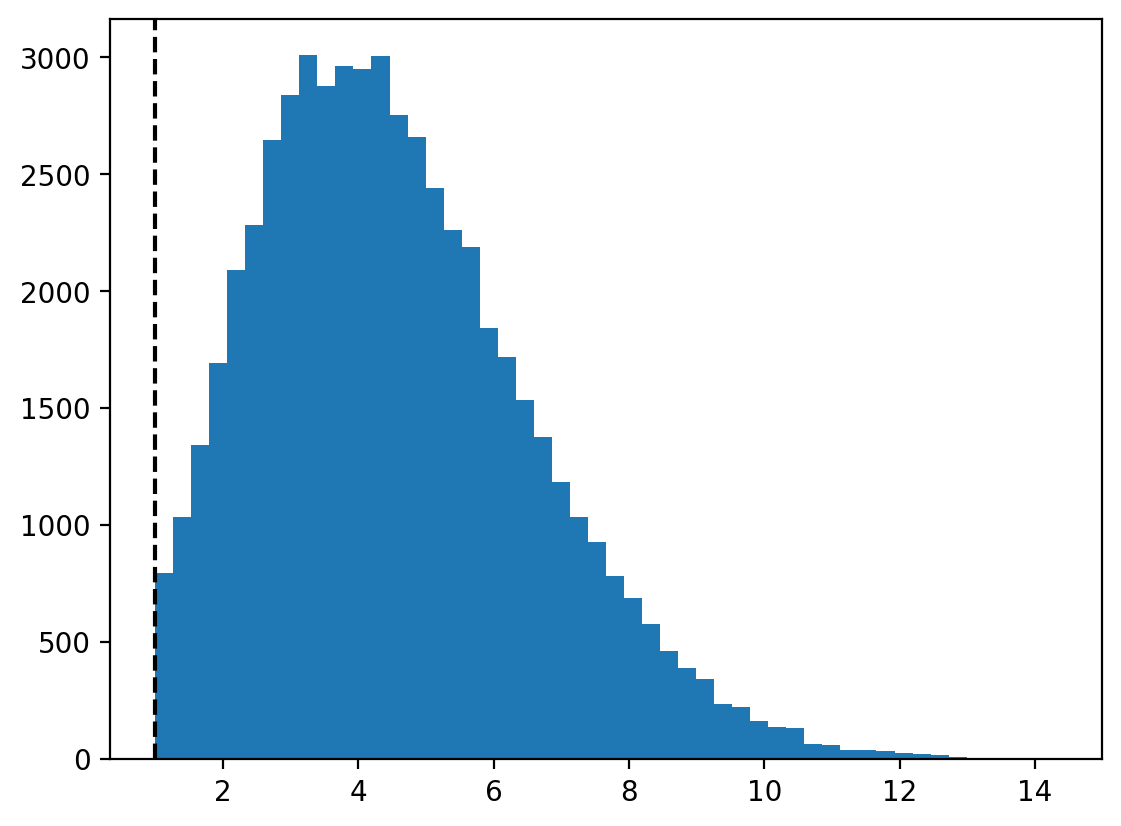

In [129]:
# How far are the nearest objects to the no matches?

nm_filt = matched_extended==6
nm_dists = np.zeros(np.sum(nm_filt))

for i,nm_coord in enumerate(obj_coords[nm_filt]):
    d, _ = true_tree.query(nm_coord)
    nm_dists[i] = d

plt.hist(nm_dists * 3600, bins=50)
plt.axvline(x=1, color='black', ls='--')

In [51]:
def fmatch_mag(observe, obs_lbls, lbl_match=[1], 
               add_filt=None, blen=6, bands=list('ugrizy')):
    # lbl_match should be a list!!!
    
    # For each band, bin using the kron magnitude.

    # Using the i_digitize to index the binning, calculate the number of objects
    # that are above some threshold and use poisson statistics to estimate
    # the error.
    
    fstar_blend_mag = np.zeros((blen,50))
    fstar_blend_err = np.zeros_like(fstar_blend_mag)
    fstar_bins = np.zeros_like(fstar_blend_mag)

    f_num = np.zeros_like(fstar_blend_mag)

    l_obs = len(obs_lbls)
    
    for i,b in enumerate(bands):
        kron_band = b+'_kron_mag'
        # b_bins = np.linspace(obj_tract[kron_band].min(), obj_tract[kron_band].max()-5, 50)
        b_bins = np.linspace(14.5, 30, 50)
        fstar_bins[i] = b_bins
        b_digitize = np.digitize(observe[kron_band], b_bins)
    
        for ndx in range(1,51):
            if add_filt is None:
                filt = (b_digitize==ndx)
            else:
                filt = (b_digitize==ndx) * add_filt
            if (np.sum(filt)==0):
                continue
            correct_lbl = np.zeros(l_obs).astype(bool)
            
            for lb in lbl_match:
                correct_lbl += obs_lbls==lb
                
            num_blends = np.sum(correct_lbl[filt])
            num_objs = np.sum(filt)

            f_num[i,ndx-1] = num_blends
            fstar_blend_mag[i,ndx-1] = num_blends/num_objs
            # Treating num_blends and num_objs as independent poisson
            fstar_blend_err[i,ndx-1] = (num_blends + num_blends ** 2 * num_objs / num_objs ** 2) ** (1 / 2) / num_objs
            
    return {'fraction': fstar_blend_mag, 'err': fstar_blend_err, 'bins': fstar_bins, 'num': f_num}


In [52]:
isolated_star_purity = fmatch_mag(primary_tract, matched_extended,
                      lbl_match=[0], add_filt=~primary_tract['refExtendedness'].astype(bool))
isolated_galaxy_purity = fmatch_mag(primary_tract, matched_extended,
                      lbl_match=[1], add_filt=primary_tract['refExtendedness'].astype(bool))

blend_star_purity = fmatch_mag(primary_tract, matched_extended,
                      lbl_match=[0,3,4], add_filt=~primary_tract['refExtendedness'].astype(bool))
blend_galaxy_purity = fmatch_mag(primary_tract, matched_extended,
                      lbl_match=[1,2,4], add_filt=primary_tract['refExtendedness'].astype(bool))

star_blend_fraction = fmatch_mag(primary_tract, matched_extended,
                      lbl_match=[3,4], add_filt=~primary_tract['refExtendedness'].astype(bool))
galaxy_blend_fraction = fmatch_mag(primary_tract, matched_extended,
                      lbl_match=[2,4], add_filt=primary_tract['refExtendedness'].astype(bool))

isolated_star_miss = fmatch_mag(primary_tract, matched_extended,
                      lbl_match=[1], add_filt=~primary_tract['refExtendedness'].astype(bool))
isolated_galaxy_miss = fmatch_mag(primary_tract, matched_extended,
                      lbl_match=[0], add_filt=primary_tract['refExtendedness'].astype(bool))

blend_star_miss = fmatch_mag(primary_tract, matched_extended,
                      lbl_match=[1,2], add_filt=~primary_tract['refExtendedness'].astype(bool))
blend_galaxy_miss = fmatch_mag(primary_tract, matched_extended,
                      lbl_match=[0,3], add_filt=primary_tract['refExtendedness'].astype(bool))
# galaxy_blend = fmatch_mag(primary_tract, matched_extended,
#                           lbl_match=[2,3,4], add_filt=primary_tract['refExtendedness'].astype(bool) * imag_filt)
# star_blend = fmatch_mag(primary_tract, matched_extended,
#                           lbl_match=[2,3,4], add_filt=~primary_tract['refExtendedness'].astype(bool) * imag_filt)

In [54]:
cmap = cm.tab10

In [325]:
# match_type_dict

Text(0.5, 0.01, 'Object i-mag')

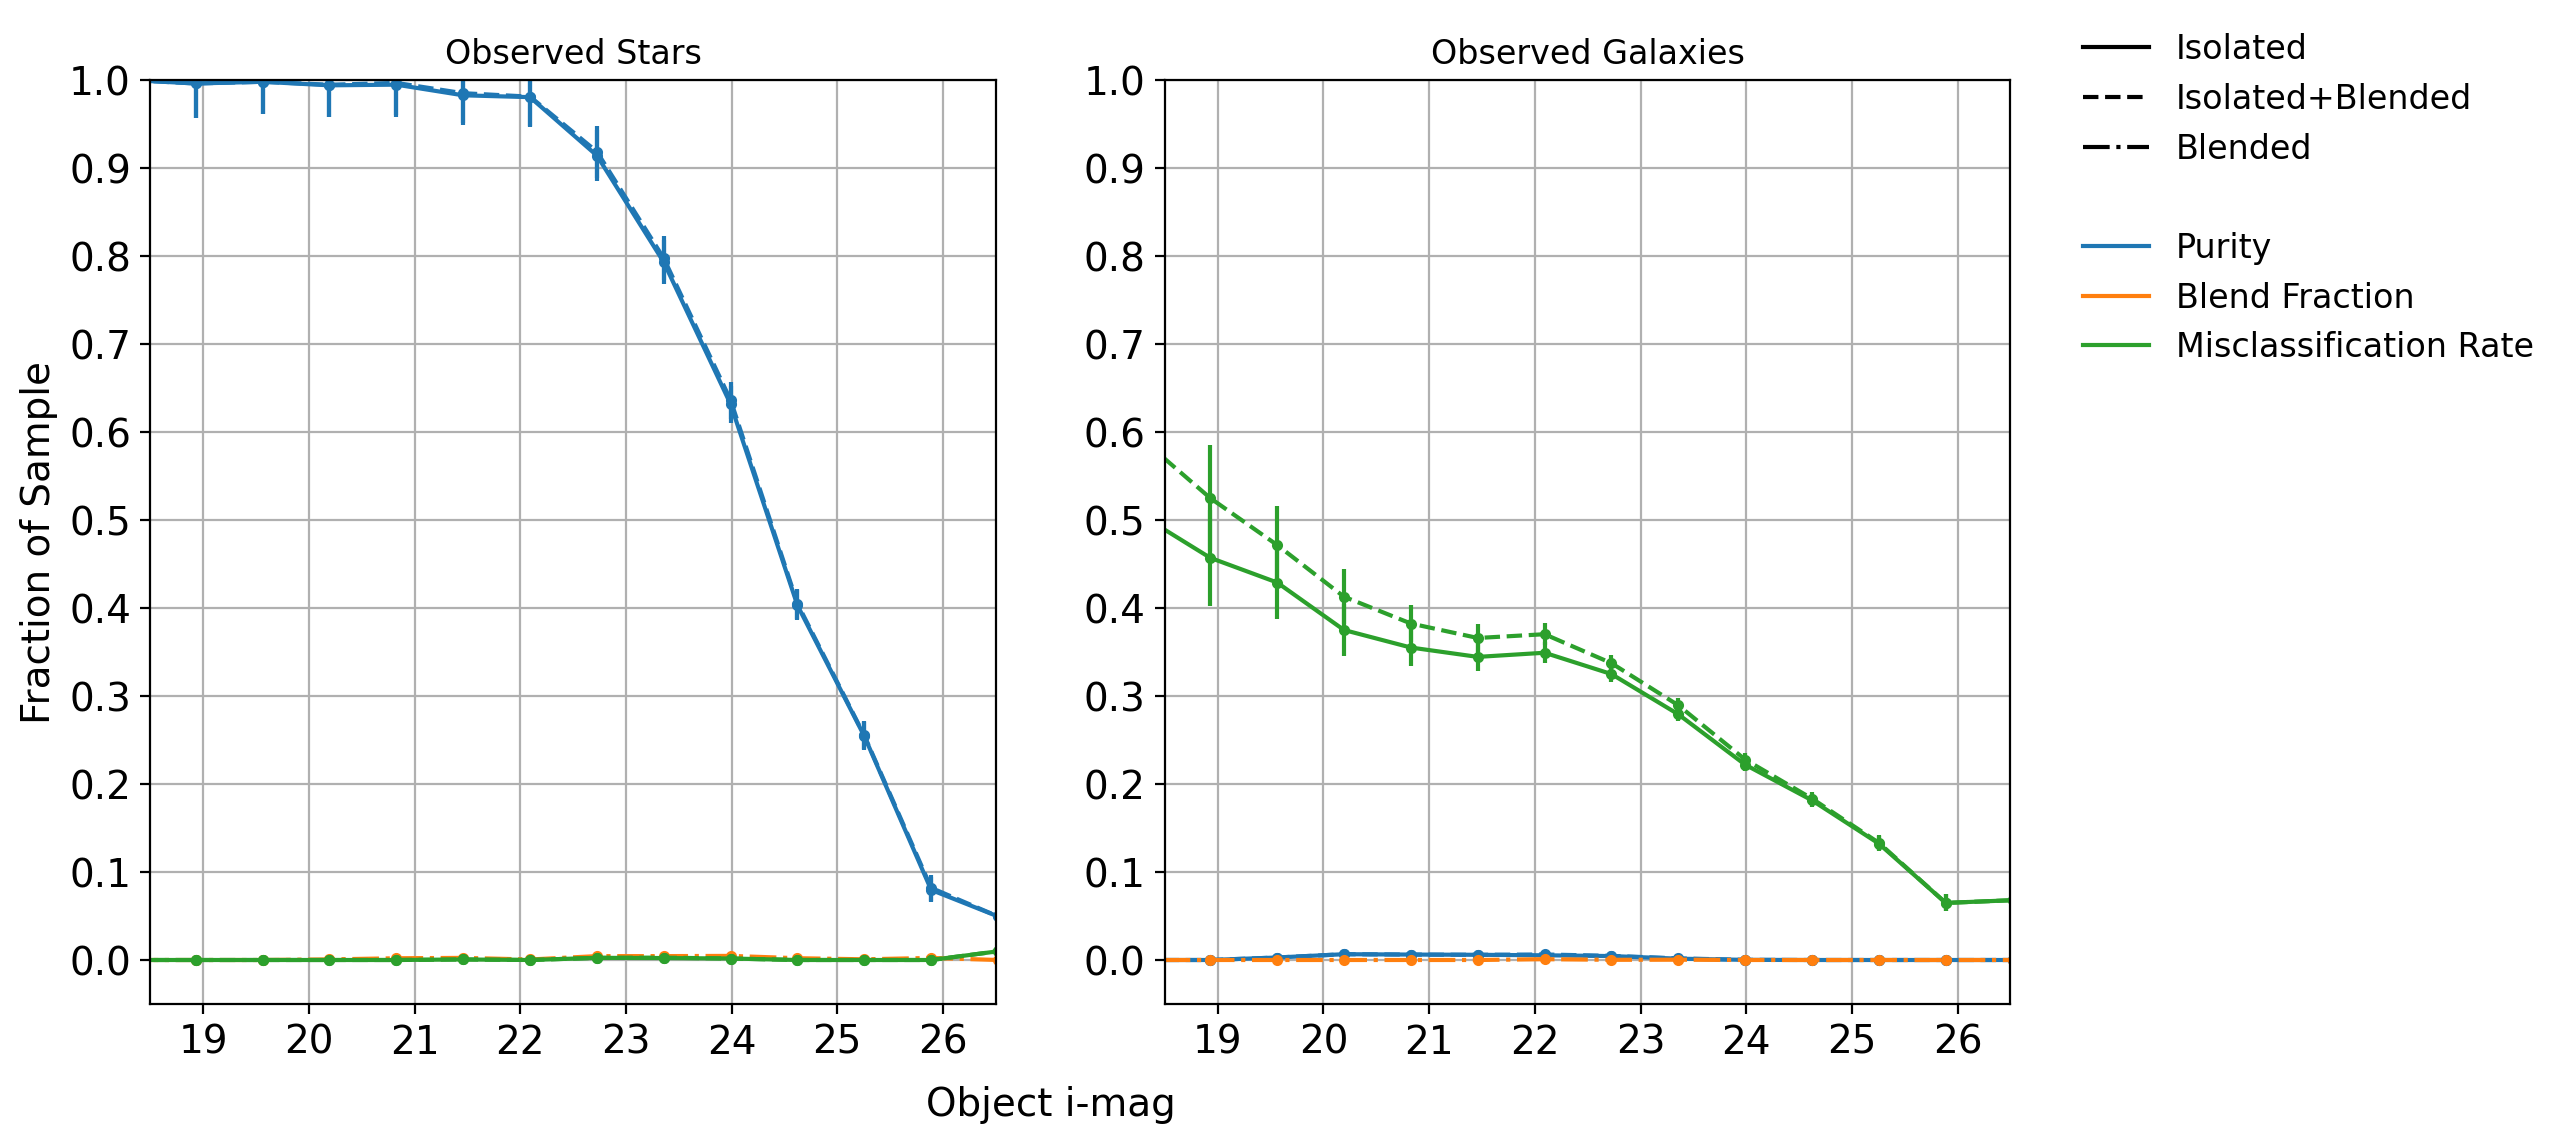

In [55]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

i=3
start_plot_ndx=6
plot_ndx_spacing = 2
ytop=1

star_plot = isolated_star_purity
galaxy_plot = isolated_galaxy_purity

ax[0].errorbar(star_plot['bins'][i,start_plot_ndx::plot_ndx_spacing],star_plot['fraction'][i,start_plot_ndx::plot_ndx_spacing],
               yerr=star_plot['err'][i,start_plot_ndx::plot_ndx_spacing], marker='.', ls='-', color=cmap(0), label="Isolated")
ax[1].errorbar(galaxy_plot['bins'][i,start_plot_ndx::plot_ndx_spacing],galaxy_plot['fraction'][i,start_plot_ndx::plot_ndx_spacing],
               yerr=galaxy_plot['err'][i,start_plot_ndx::plot_ndx_spacing], marker='.', ls='-', color=cmap(0), label="Isolated")

star_plot = blend_star_purity
galaxy_plot = blend_galaxy_purity

ax[0].errorbar(star_plot['bins'][i,start_plot_ndx::plot_ndx_spacing],star_plot['fraction'][i,start_plot_ndx::plot_ndx_spacing],
               yerr=star_plot['err'][i,start_plot_ndx::plot_ndx_spacing], marker='.', ls='--', color=cmap(0), label="Isolated+Blended")
ax[1].errorbar(galaxy_plot['bins'][i,start_plot_ndx::plot_ndx_spacing],galaxy_plot['fraction'][i,start_plot_ndx::plot_ndx_spacing],
               yerr=galaxy_plot['err'][i,start_plot_ndx::plot_ndx_spacing], marker='.', ls='--', color=cmap(0), label="Isolated+Blended")

star_plot = star_blend_fraction
galaxy_plot = galaxy_blend_fraction

ax[0].errorbar(star_plot['bins'][i,start_plot_ndx::plot_ndx_spacing],star_plot['fraction'][i,start_plot_ndx::plot_ndx_spacing],
               yerr=star_plot['err'][i,start_plot_ndx::plot_ndx_spacing], marker='.', ls='-.', color=cmap(1), label="Blend Fraction")
ax[1].errorbar(galaxy_plot['bins'][i,start_plot_ndx::plot_ndx_spacing],galaxy_plot['fraction'][i,start_plot_ndx::plot_ndx_spacing],
               yerr=galaxy_plot['err'][i,start_plot_ndx::plot_ndx_spacing], marker='.', ls='-.', color=cmap(1), label="Blend Fraction")

star_plot = isolated_star_miss
galaxy_plot = isolated_galaxy_miss

ax[0].errorbar(star_plot['bins'][i,start_plot_ndx::plot_ndx_spacing],star_plot['fraction'][i,start_plot_ndx::plot_ndx_spacing],
               yerr=star_plot['err'][i,start_plot_ndx::plot_ndx_spacing], marker='.', ls='-', color=cmap(2), label="Isolated")
ax[1].errorbar(galaxy_plot['bins'][i,start_plot_ndx::plot_ndx_spacing],galaxy_plot['fraction'][i,start_plot_ndx::plot_ndx_spacing],
               yerr=galaxy_plot['err'][i,start_plot_ndx::plot_ndx_spacing], marker='.', ls='-', color=cmap(2), label="Isolated")

star_plot = blend_star_miss
galaxy_plot = blend_galaxy_miss

ax[0].errorbar(star_plot['bins'][i,start_plot_ndx::plot_ndx_spacing],star_plot['fraction'][i,start_plot_ndx::plot_ndx_spacing],
               yerr=star_plot['err'][i,start_plot_ndx::plot_ndx_spacing], marker='.', ls='--', color=cmap(2), label="Isolated+Blended")
ax[1].errorbar(galaxy_plot['bins'][i,start_plot_ndx::plot_ndx_spacing],galaxy_plot['fraction'][i,start_plot_ndx::plot_ndx_spacing],
               yerr=galaxy_plot['err'][i,start_plot_ndx::plot_ndx_spacing], marker='.', ls='--', color=cmap(2), label="Isolated+Blended")

for xx in ax:
    # xx.semilogx()
    xx.grid(visible=True)
    # xx.legend()
    xx.set_ylim(bottom=-.05, top=ytop)
    xx.set_xlim(18.5, 26.5)
    xx.set_yticks(np.arange(0,ytop+.05,.1))
    for item in (xx.get_xticklabels() + xx.get_yticklabels()):
        item.set_fontsize(14)

# ax[0].set_ylim(bottom=-.05, top=1.05)
ax[0].set_title("Observed Stars")
ax[1].set_title("Observed Galaxies")
# ax[1].legend(


# ax[0].set_ylabel("Blend Fraction", fontsize=16, color=cmap(1), x=-.5)
# ax[0].annotate("Misclassification Rate", xy=(-.2,.5), xycoords='axes fraction', rotate=90)
# ax[0].set_ylabel("Misclassification Rate", fontsize=16, color=cmap(2), x=19)
ax[1].legend(handles=[
    plt.Line2D([], [], linestyle='-', color='black', label='Isolated'),
    plt.Line2D([], [], linestyle='--', color='black', label='Isolated+Blended'),
    plt.Line2D([], [], linestyle='-.', color='black', label='Blended'),
    plt.Line2D([], [], linestyle='-.', color='white', label=''),
    plt.Line2D([], [], linestyle='-', color=cmap(0), label='Purity'),
    plt.Line2D([], [], linestyle='-', color=cmap(1), label='Blend Fraction'),
    plt.Line2D([], [], linestyle='-', color=cmap(2), label='Misclassification Rate'),
],frameon=False, bbox_to_anchor=(1.05,.66), fontsize=12)
ax[0].set_ylabel("Fraction of Sample", fontsize=14,color='black')
fig.supxlabel(r"Object i-mag", fontsize=14)